# Bloque 1: Configuración inicial y carga de datos
En este bloque:
1. Importamos las librerías necesarias para el análisis de datos, preprocesamiento, modelado y visualización.
2. Configuramos las opciones de Pandas para una mejor visualización de datos.
3. Cargamos el dataset desde un archivo CSV, verificamos su contenido inicial, la estructura de datos, y la cantidad de valores faltantes en cada columna.
4. Si no se encuentra el archivo, mostramos un error y detenemos la ejecución del programa.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Ajustar configuraciones de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Ruta del dataset
file_path = "./data/EUROREPO.csv"

try:
    # Cargar el dataset
    df = pd.read_csv(file_path)

    # Exploración inicial
    print("Vista inicial del dataset:")
    print(df.head())

    print("\nInformación general del dataset:")
    df.info()

    print("\nValores nulos por columna:")
    print(df.isnull().sum())

    print("\nPorcentaje de valores nulos por columna:")
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    print(missing_percentage)

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta especificada: {file_path}")
    exit()


Vista inicial del dataset:
     ID                                               name                                        description  start_date       end_date                           inclusion_criteria inclusion_criteria_subcode       source_incident_detection_disclosure                                      incident_type                                      receiver_name                        receiver_country      receiver_region                                  receiver_category receiver_category_subcode                     initiator_name initiator_country initiator_category initiator_category_subcode  number_of_attributions attribution_ID     attribution_date                                   attribution_type  attribution_basis       attributing_actor attribution_it_company attributing_country               attributed_initiator attributed_initiator_country attributed_initiator_category                                sources_attribution cyber_conflict_issue offline_conflict_is

# Bloque 2: Limpieza inicial del dataset
1. Identificamos y eliminamos columnas con más del 70% de valores nulos, ya que aportan poca información útil.
2. Convertimos columnas que representan fechas al formato `datetime` para facilitar su manipulación en análisis posteriores.
3. Imprimimos las columnas eliminadas y confirmamos la correcta conversión de fechas.


In [4]:
# Paso 1: Eliminar columnas con más del 70% de valores nulos
null_percentage = df.isnull().mean() * 100
columns_to_drop = null_percentage[null_percentage > 70].index
data_cleaned = df.drop(columns=columns_to_drop)
print(f"\nColumnas eliminadas: {list(columns_to_drop)}")

# Paso 2: Convertir columnas de fechas
date_columns = ['start_date', 'end_date', 'attribution_date', 'political_response_date', 'added_to_DB', 'updated_at']
for col in date_columns:
    if col in data_cleaned.columns:
        data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')

print("\nColumnas de fechas convertidas correctamente.")



Columnas eliminadas: ['inclusion_criteria_subcode', 'offline_conflict_issue_subcode', 'offline_conflict_intensity_subcode', 'political_response_date', 'political_response_type_subcode', 'zero_days_subcode', 'economic_impact', 'legal_response_date', 'legal_response_type_subcode', 'legal_attribution_reference_subcode', 'casualties']

Columnas de fechas convertidas correctamente.


# Bloque 3: Conversión de columnas categóricas y manejo de valores faltantes
1. Convertimos columnas categóricas relevantes al tipo `category`, lo que reduce el uso de memoria y facilita el preprocesamiento.
2. Rellenamos valores faltantes en columnas numéricas con la media de cada columna.
3. Rellenamos valores faltantes en columnas categóricas con la categoría `Unknown`.


In [5]:
# Paso 3: Convertir columnas categóricas
categorical_columns = [
    'incident_type', 'receiver_country', 'receiver_region', 'receiver_category',
    'initiator_country', 'initiator_category', 'economic_impact_currency'
]
for col in categorical_columns:
    if col in data_cleaned.columns:
        data_cleaned[col] = data_cleaned[col].astype('category')

print("\nColumnas categóricas convertidas correctamente.")

# Paso 4: Manejo de valores faltantes
numeric_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
data_cleaned[numeric_columns] = data_cleaned[numeric_columns].fillna(data_cleaned[numeric_columns].mean())

categorical_columns = data_cleaned.select_dtypes(include=['category', 'object']).columns
for col in categorical_columns:
    if data_cleaned[col].dtype.name == "category":
        if "Unknown" not in data_cleaned[col].cat.categories:
            data_cleaned[col] = data_cleaned[col].cat.add_categories(["Unknown"])
data_cleaned[categorical_columns] = data_cleaned[categorical_columns].fillna('Unknown')

print("\nValores faltantes manejados correctamente.")



Columnas categóricas convertidas correctamente.

Valores faltantes manejados correctamente.


# Bloque 4: Preprocesamiento y división de los datos
1. Definimos una función para convertir columnas no numéricas en datos procesables. Usamos `LabelEncoder` o extraemos valores numéricos de cadenas.
2. Seleccionamos las columnas que serán utilizadas como características (`X`) y como variable objetivo (`y`).
3. Dividimos los datos en conjuntos de entrenamiento y prueba.
4. Aplicamos escalado a los datos para normalizar las variables numéricas.


In [6]:
# Paso 5: Procesar columnas no numéricas
def convertir_columnas_no_numericas(X):
    non_numeric_columns = X.select_dtypes(include=['object', 'category']).columns

    for col in non_numeric_columns:
        if X[col].str.contains("Weeks", na=False).any():
            X[col] = X[col].str.extract(r'(\d+)').astype(float).fillna(0)
        else:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

    return X

# Selección de características y variable objetivo
feature_columns = ['unweighted_cyber_intensity', 'weighted_cyber_intensity', 'functional_impact', 'political_impact_affected_entities_exact_value']
target_column = 'impact_indicator_value'

data_for_model = data_cleaned[feature_columns + [target_column]].dropna()
X = data_for_model[feature_columns]
y = data_for_model[target_column]

# Procesar columnas no numéricas
X = convertir_columnas_no_numericas(X)

# Paso 6: División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_20360\2772120474.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].str.extract(r'(\d+)').astype(float).fillna(0)


# Bloque 5: Entrenamiento y evaluación del modelo
1. Usamos `GridSearchCV` para encontrar los mejores hiperparámetros del modelo `RandomForestRegressor` mediante validación cruzada.
2. Entrenamos el modelo optimizado y hacemos predicciones sobre los datos de prueba.
3. Calculamos métricas de desempeño: `MSE` (Error Cuadrático Medio), `R²` (Coeficiente de Determinación) y `MAE` (Error Absoluto Medio).


In [7]:
# Paso 7: Modelo y optimización con GridSearchCV
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='r2', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Paso 8: Evaluación del modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R²: {r2}")
print(f"MAE: {mae}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
MSE: 3.226495519069838
R²: 0.7214441842387012
MAE: 1.1014212668878596


# Bloque 6: Visualización de resultados
1. Graficamos las predicciones del modelo frente a los valores reales para evaluar visualmente el desempeño.
2. Mostramos la importancia de las características según el modelo entrenado.
3. Graficamos los residuos (diferencia entre predicciones y valores reales) para identificar patrones en los errores.


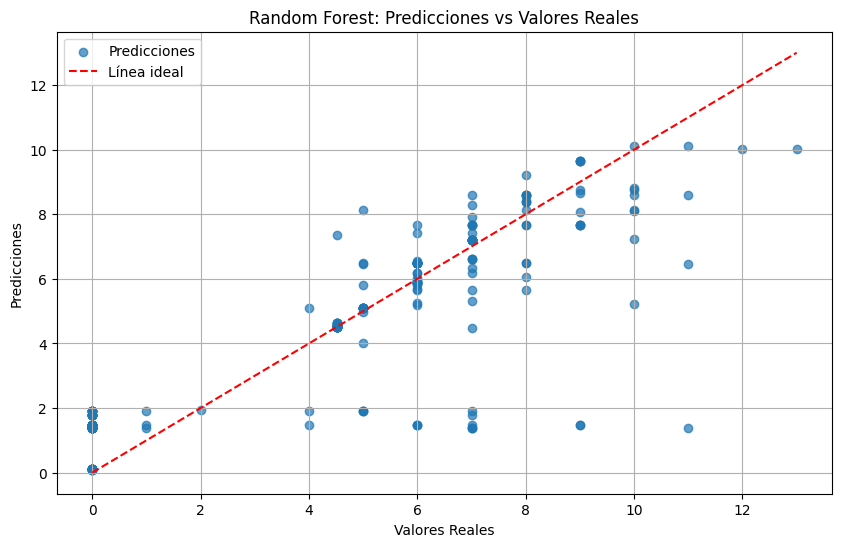

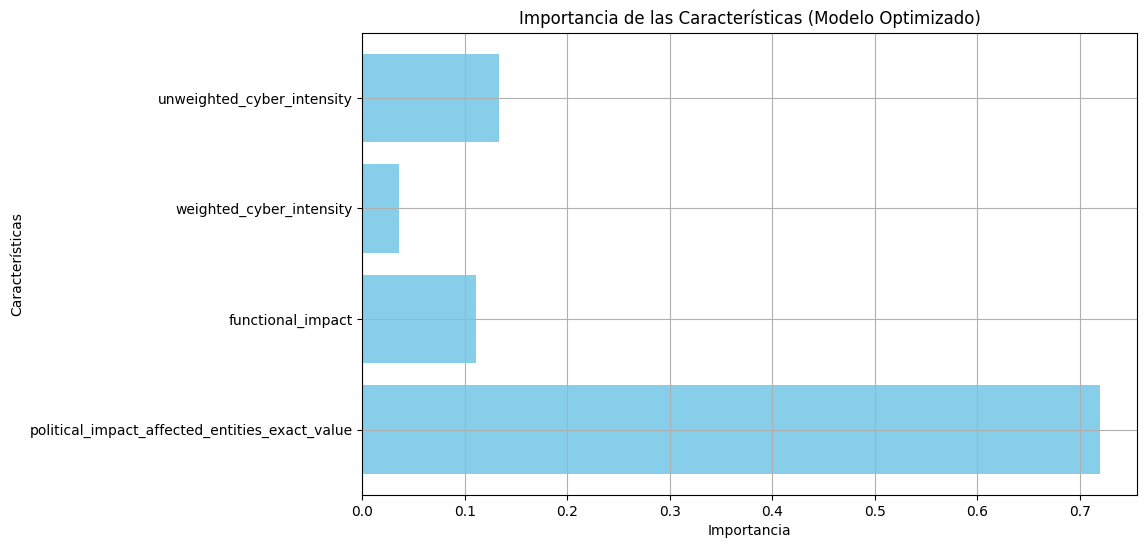

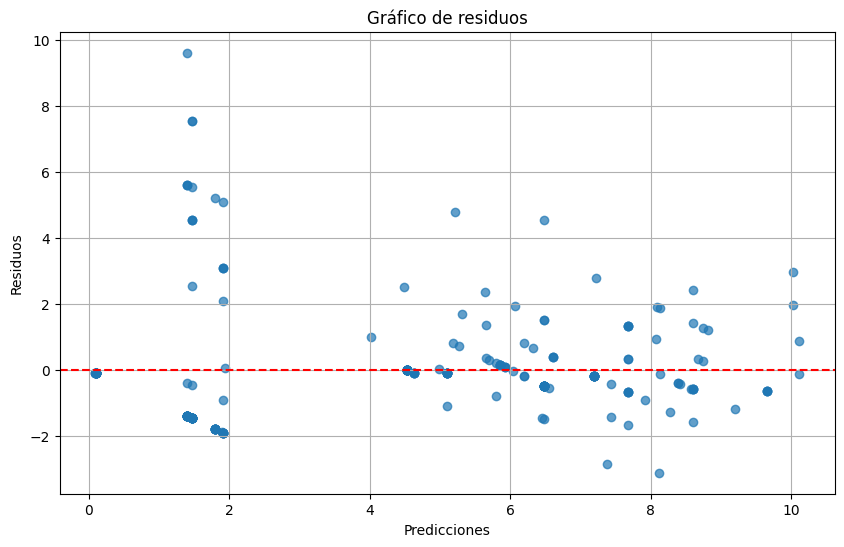

In [8]:
# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Línea ideal')
plt.title('Random Forest: Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
plt.grid()
plt.show()

# Importancia de características
importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, importances, color='skyblue')
plt.title('Importancia de las Características (Modelo Optimizado)')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

# Gráfico de residuos
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Gráfico de residuos')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.grid()
plt.show()


# Bloque 7: Análisis Exploratorio
1. Generar un boxplot para analizar la dispersión y detectar posibles outliers en una de las variables numéricas.
2. Crear un gráfico de frecuencias para visualizar la distribución de las categorías de incidentes.
3. Usar un histograma para observar la distribución de una característica numérica clave.


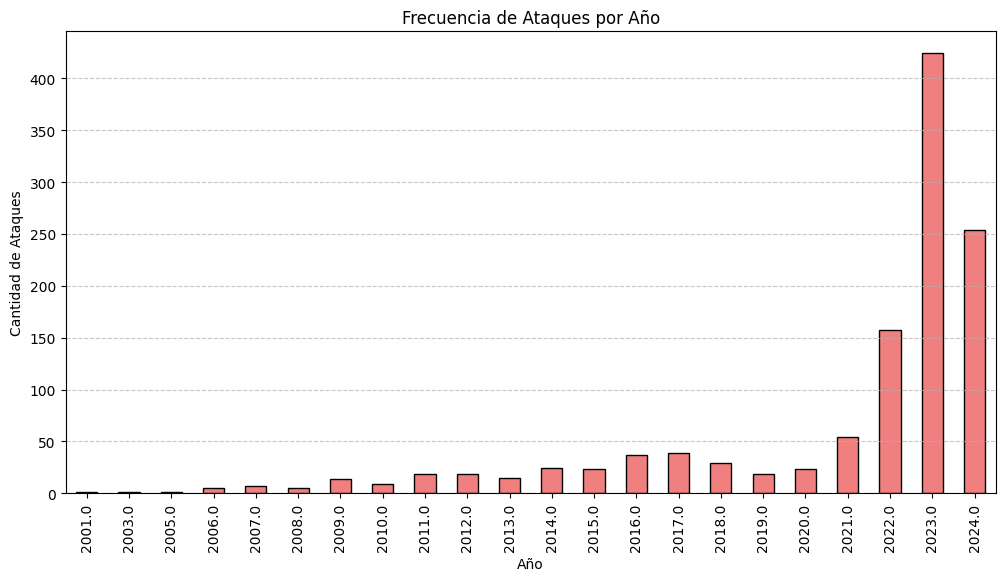

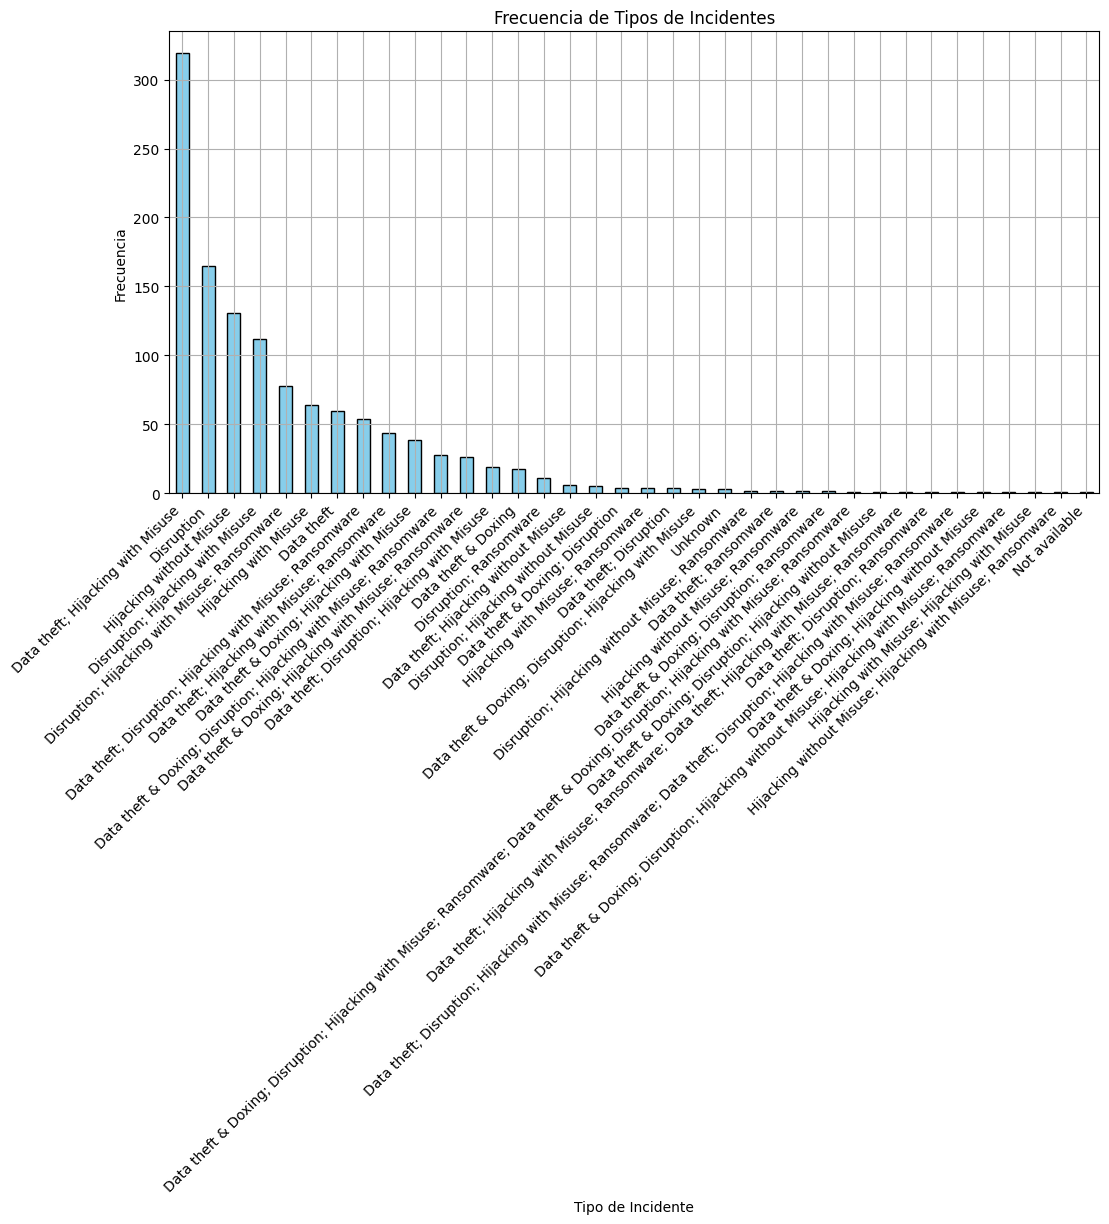

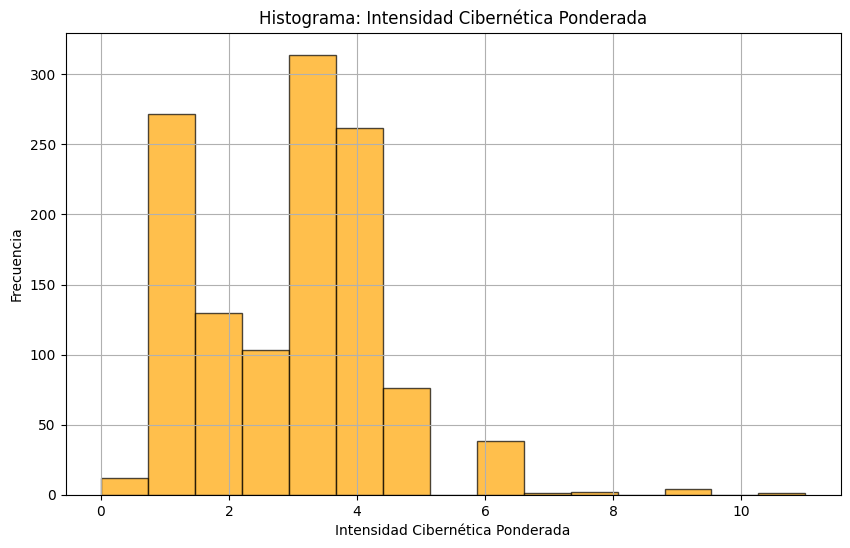

In [9]:
# Verificar si existe la columna 'start_date' y convertir a datetime si es necesario
if 'start_date' in data_cleaned.columns:
    data_cleaned['start_date'] = pd.to_datetime(data_cleaned['start_date'], errors='coerce')
    data_cleaned['year'] = data_cleaned['start_date'].dt.year  # Extraer el año

    # Contar la frecuencia de ataques por año
    attacks_per_year = data_cleaned['year'].value_counts().sort_index()

    # Graficar la frecuencia de ataques por año
    plt.figure(figsize=(12, 6))
    attacks_per_year.plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title('Frecuencia de Ataques por Año')
    plt.xlabel('Año')
    plt.ylabel('Cantidad de Ataques')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("La columna 'start_date' no está disponible en el dataset.")


# Gráfico de frecuencias para los tipos de incidentes
incident_counts = data_cleaned['incident_type'].value_counts()
plt.figure(figsize=(12, 6))
incident_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frecuencia de Tipos de Incidentes')
plt.xlabel('Tipo de Incidente')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

# Histograma para la variable 'weighted_cyber_intensity'
plt.figure(figsize=(10, 6))
plt.hist(data_cleaned['weighted_cyber_intensity'].dropna(), bins=15, color='orange', edgecolor='black', alpha=0.7)
plt.title('Histograma: Intensidad Cibernética Ponderada')
plt.xlabel('Intensidad Cibernética Ponderada')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()


# Bloque 8: Representación gráfica de métricas de evaluación
1. Crear un gráfico de barras para comparar las métricas MSE, R² y MAE obtenidas durante la evaluación del modelo.
2. Visualizar gráficamente las métricas ayuda a entender mejor el rendimiento del modelo.


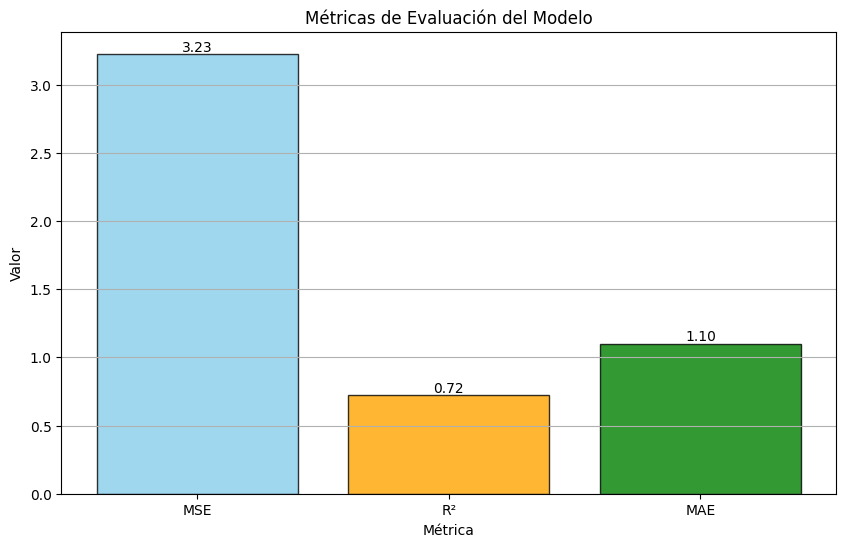

In [10]:
# Métricas de evaluación
metrics = {'MSE': mse, 'R²': r2, 'MAE': mae}
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Gráfico de barras para las métricas
plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color=['skyblue', 'orange', 'green'], edgecolor='black', alpha=0.8)
plt.title('Métricas de Evaluación del Modelo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.grid(axis='y')
for i, value in enumerate(metric_values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)
plt.show()


# OTROS GRAFICOS

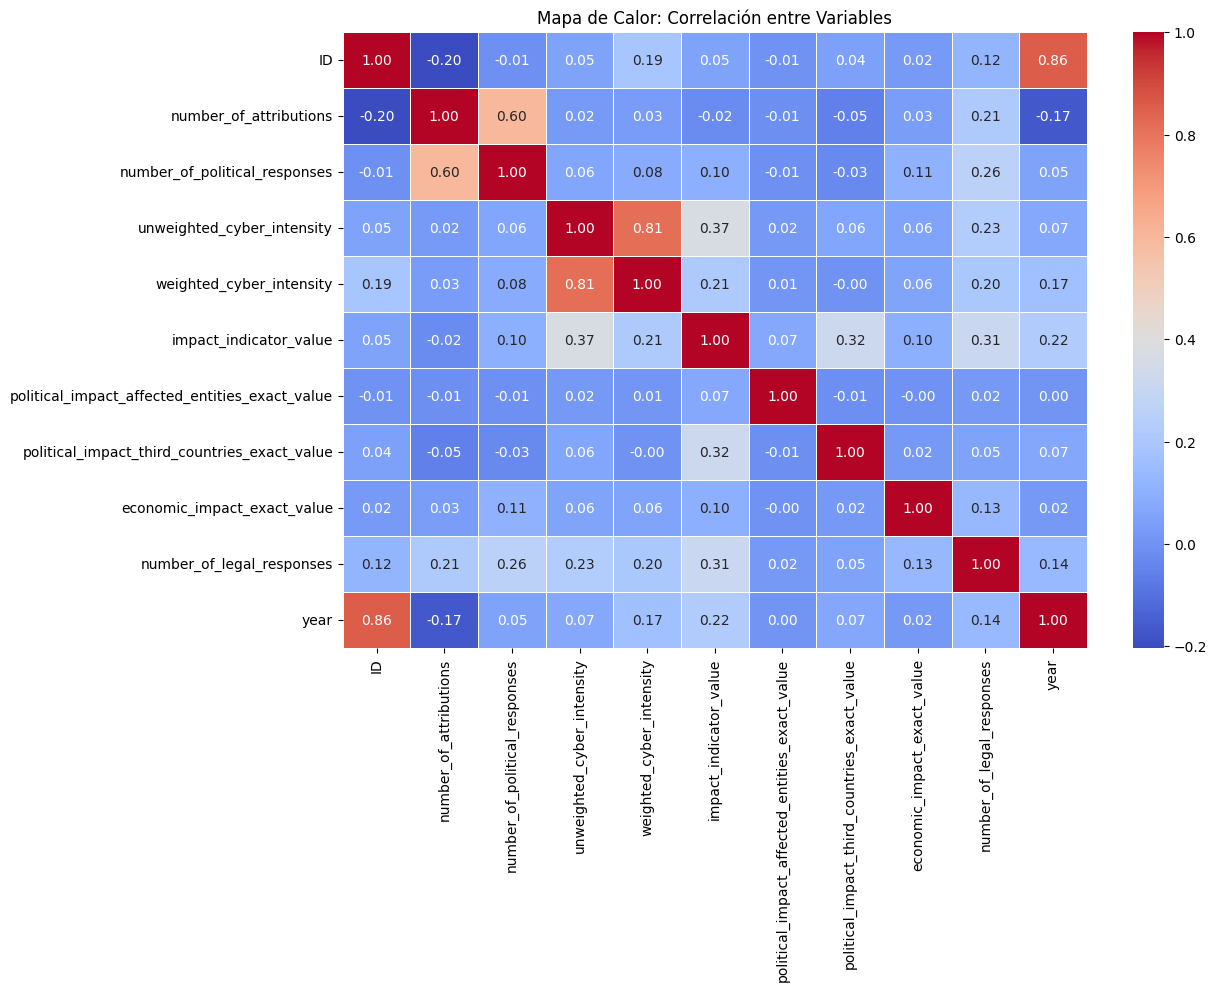

In [11]:
import seaborn as sns

# Seleccionar columnas numéricas para el análisis de correlación
numeric_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_cleaned[numeric_columns].corr()

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor: Correlación entre Variables')
plt.show()


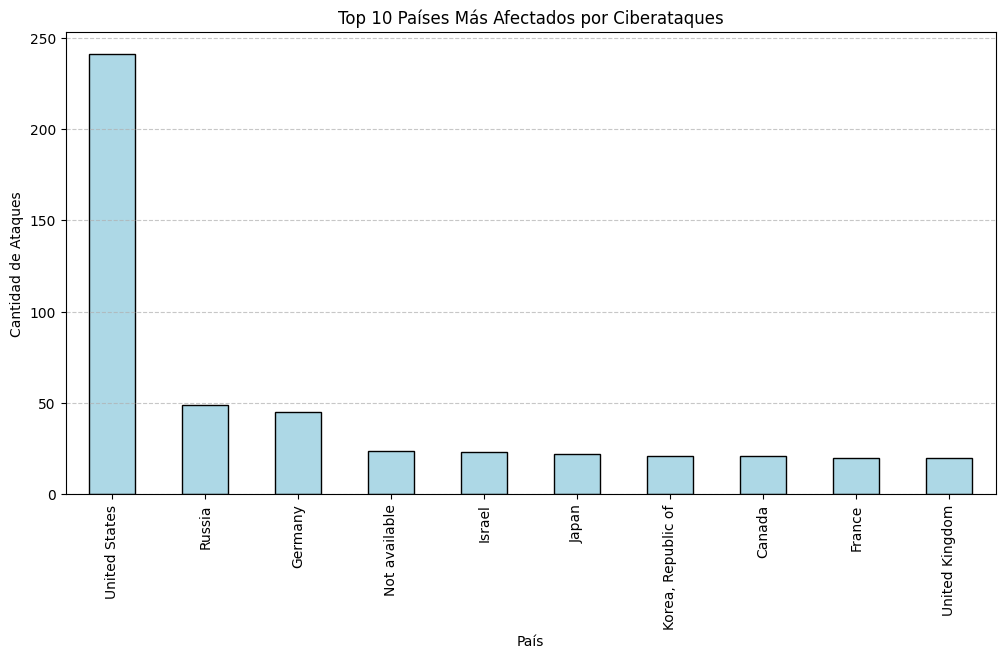

In [12]:
# Contar ataques por país
if 'receiver_country' in data_cleaned.columns:
    country_counts = data_cleaned['receiver_country'].value_counts().head(10)  # Top 10 países

    # Gráfico de barras para países más afectados
    plt.figure(figsize=(12, 6))
    country_counts.plot(kind='bar', color='lightblue', edgecolor='black')
    plt.title('Top 10 Países Más Afectados por Ciberataques')
    plt.xlabel('País')
    plt.ylabel('Cantidad de Ataques')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("La columna 'receiver_country' no está disponible en el dataset.")


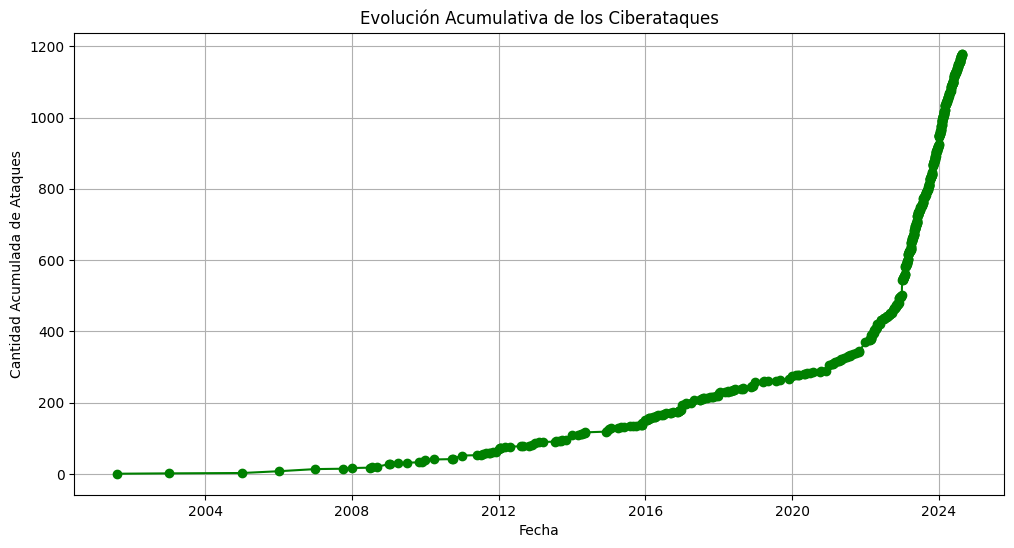

In [13]:
if 'start_date' in data_cleaned.columns:
    attacks_timeline = data_cleaned['start_date'].dropna().value_counts().sort_index()
    cumulative_attacks = attacks_timeline.cumsum()

    # Gráfico de línea acumulativa
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_attacks.index, cumulative_attacks, marker='o', linestyle='-', color='green')
    plt.title('Evolución Acumulativa de los Ciberataques')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad Acumulada de Ataques')
    plt.grid()
    plt.show()
else:
    print("La columna 'start_date' no está disponible en el dataset.")


C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_20360\2895688253.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


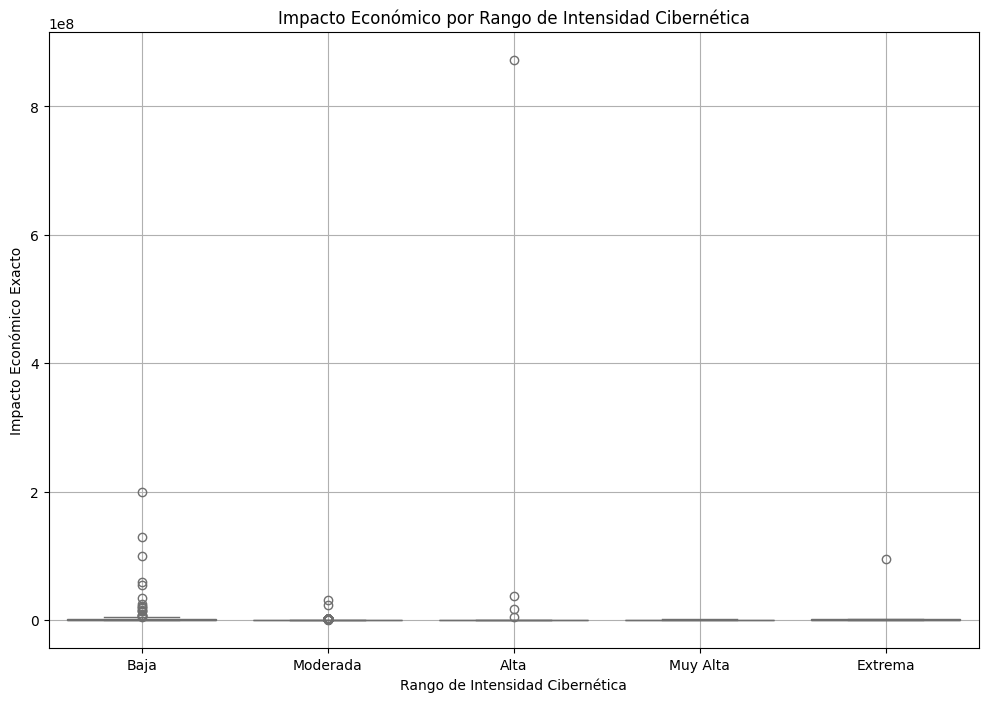

In [14]:
if 'economic_impact_exact_value' in data_cleaned.columns and 'weighted_cyber_intensity' in data_cleaned.columns:
    # Crear rangos para la intensidad cibernética
    data_cleaned['intensity_bins'] = pd.cut(
        data_cleaned['weighted_cyber_intensity'], bins=5, labels=['Baja', 'Moderada', 'Alta', 'Muy Alta', 'Extrema']
    )
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        x='intensity_bins', 
        y='economic_impact_exact_value', 
        data=data_cleaned, 
        palette='pastel'
    )
    plt.title('Impacto Económico por Rango de Intensidad Cibernética')
    plt.xlabel('Rango de Intensidad Cibernética')
    plt.ylabel('Impacto Económico Exacto')
    plt.grid()
    plt.show()
else:
    print("Las columnas necesarias no están disponibles en el dataset.")


C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_20360\2517117708.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_intensity_by_type = data_cleaned.groupby('incident_type')['weighted_cyber_intensity'].mean().sort_values(ascending=False).head(10)


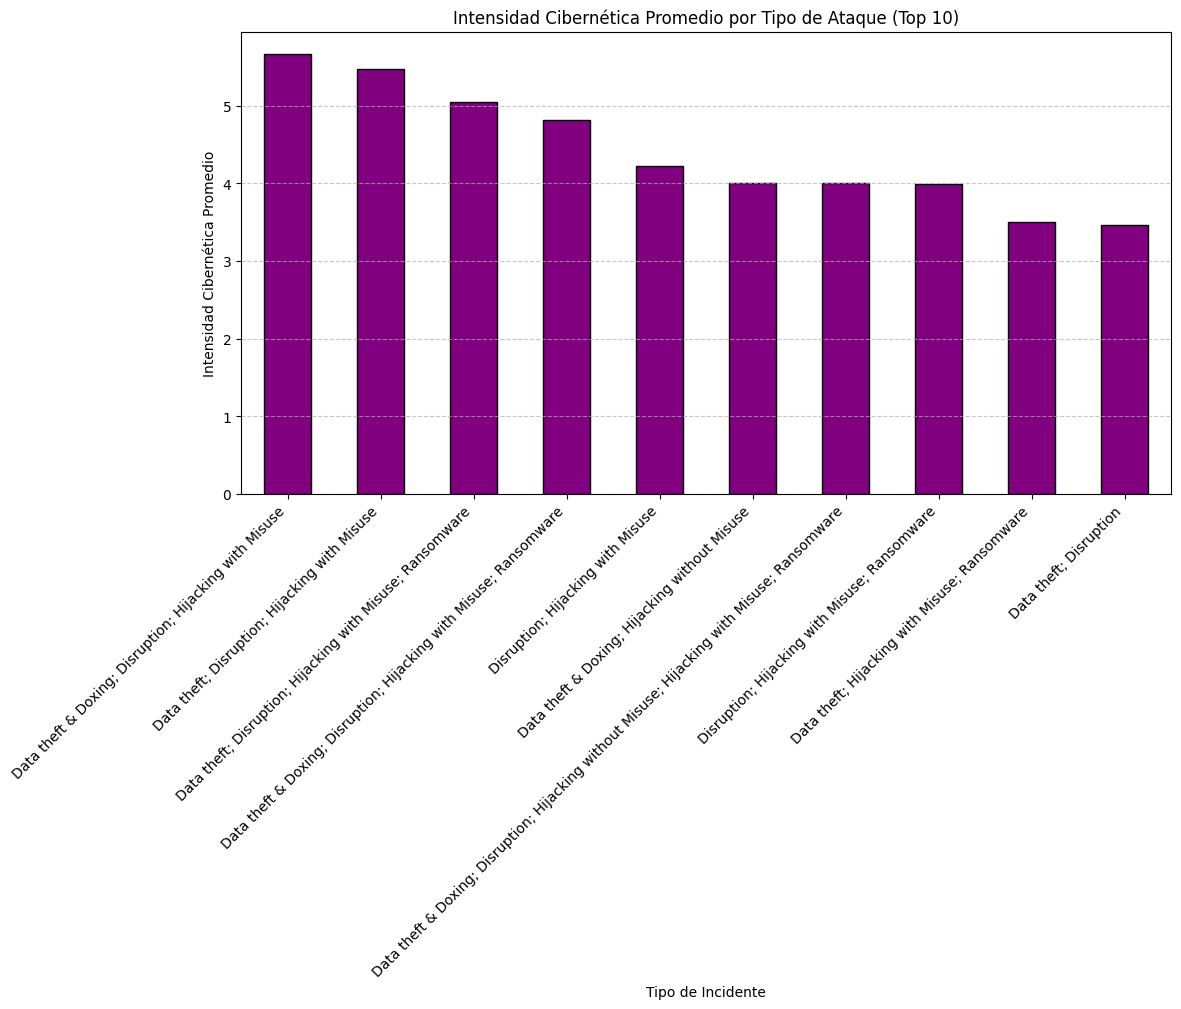

In [15]:
if 'incident_type' in data_cleaned.columns and 'weighted_cyber_intensity' in data_cleaned.columns:
    avg_intensity_by_type = data_cleaned.groupby('incident_type')['weighted_cyber_intensity'].mean().sort_values(ascending=False).head(10)

    # Gráfico de barras para intensidad promedio por tipo de ataque
    plt.figure(figsize=(12, 6))
    avg_intensity_by_type.plot(kind='bar', color='purple', edgecolor='black')
    plt.title('Intensidad Cibernética Promedio por Tipo de Ataque (Top 10)')
    plt.xlabel('Tipo de Incidente')
    plt.ylabel('Intensidad Cibernética Promedio')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Las columnas necesarias no están disponibles en el dataset.")


## Frecuencia de Ciberataques por Mes y Año

Este bloque genera gráficos de barras para mostrar la frecuencia de ciberataques por mes, separando los datos por los años: 2020, 2021, 2022, 2023 y 2024. 

### Pasos Clave:
1. **Conversión de la columna 'start_date'**:
   - Se verifica que la columna `start_date` esté en formato `datetime`. Si no, se convierte utilizando `pd.to_datetime`.

2. **Filtrado por años específicos**:
   - Se seleccionan los ciberataques ocurridos en los años 2020, 2021, 2022, 2023 y 2024 mediante la extracción del año de la columna `start_date`.

3. **Cálculo de ciberataques por mes**:
   - Para cada año, se crea una nueva columna `month` que extrae el mes de la fecha de inicio del ciberataque.
   - Se cuentan los ciberataques por mes utilizando `value_counts()` y se ordenan los resultados.

4. **Generación de gráficos de barras**:
   - Cada gráfico representa un año y muestra los meses en el eje X y la cantidad de ciberataques en el eje Y.
   - Se estilizan los gráficos con colores, etiquetas descriptivas y cuadrículas para facilitar la lectura.

### Uso del Gráfico:
- Este análisis ayuda a identificar patrones estacionales en los ciberataques.
- Podrás ver en qué meses se producen más incidentes para planificar medidas de **prevención y respuesta**.

### Notas:
- Si no hay datos para un año específico, se imprime un mensaje indicando que no se encontraron ciberataques.


C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_20360\557823992.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['month'] = data_filtered['start_date'].dt.month


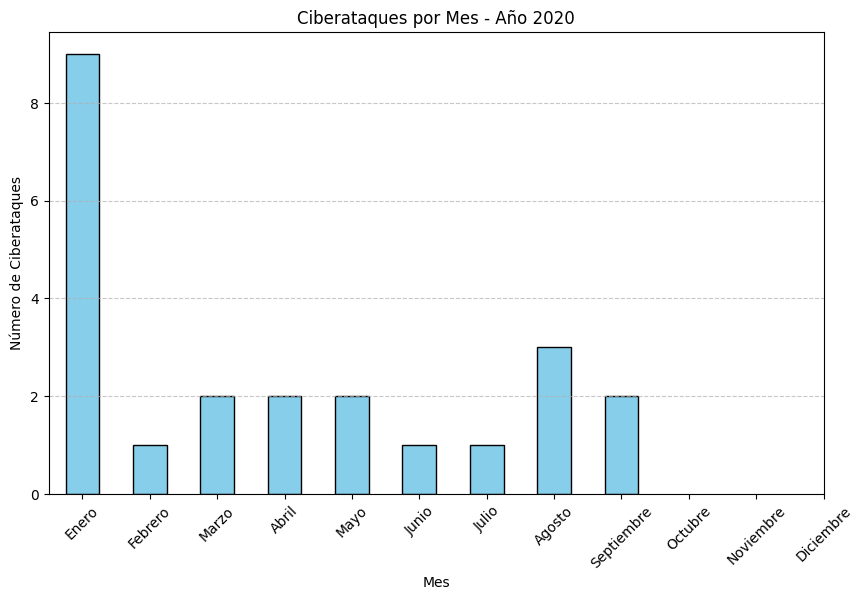

C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_20360\557823992.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['month'] = data_filtered['start_date'].dt.month


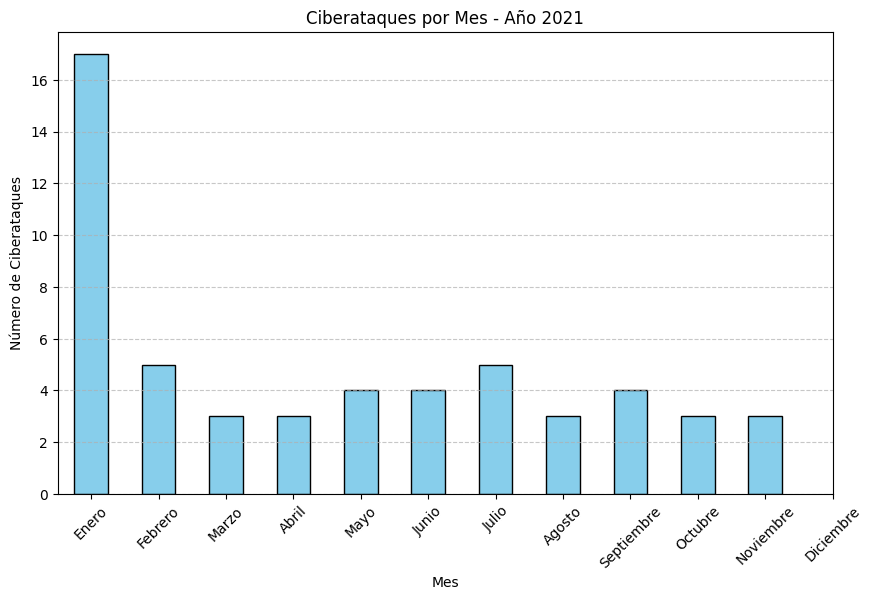

C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_20360\557823992.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['month'] = data_filtered['start_date'].dt.month


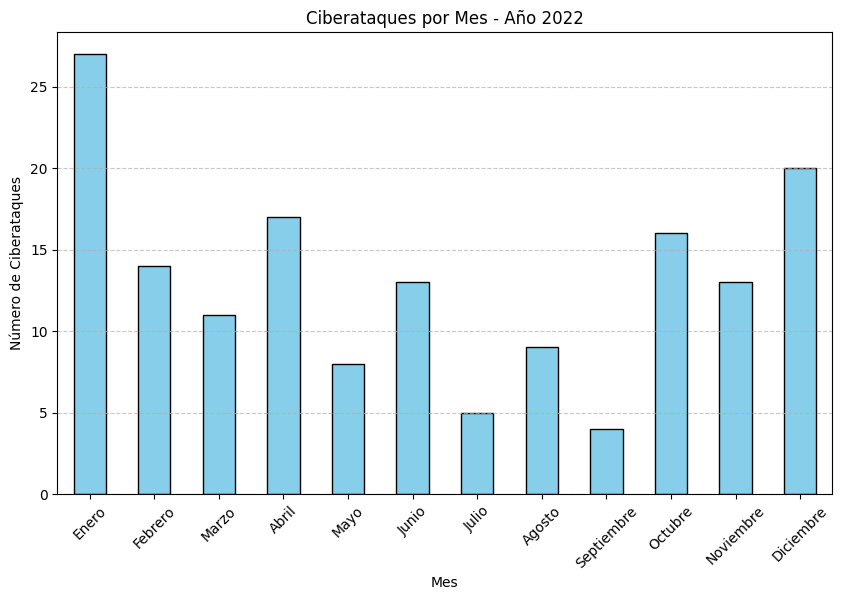

C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_20360\557823992.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['month'] = data_filtered['start_date'].dt.month


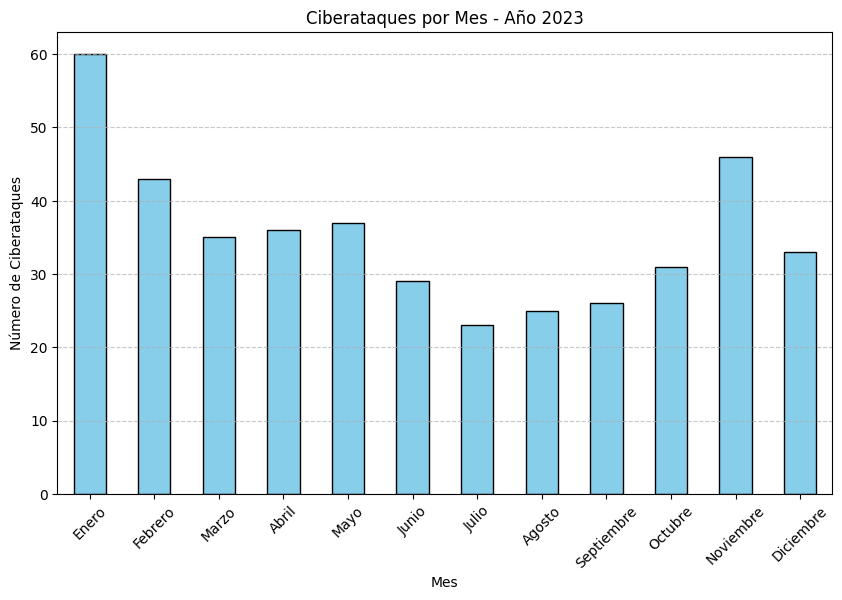

C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_20360\557823992.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['month'] = data_filtered['start_date'].dt.month


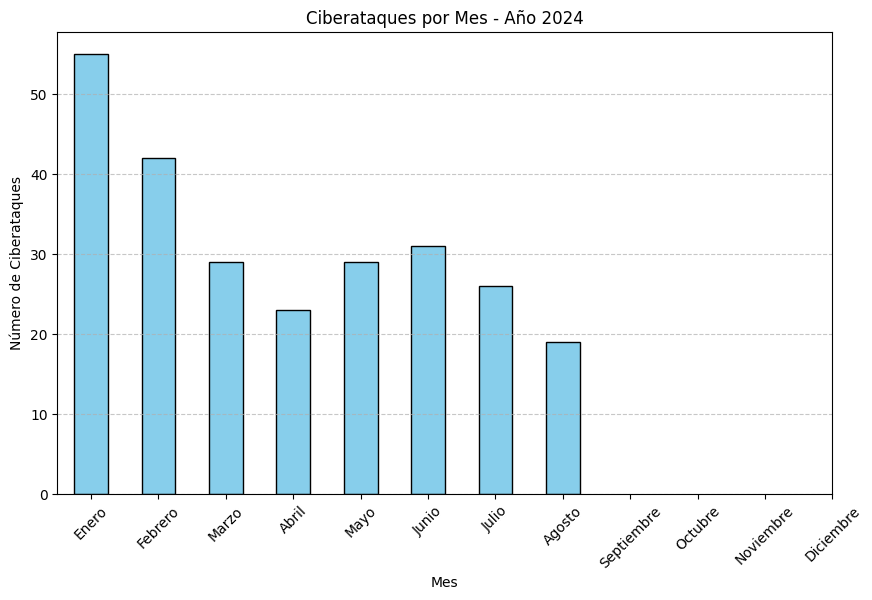

In [16]:
import matplotlib.pyplot as plt

# Asegurarse de que la columna 'start_date' sea de tipo datetime
if not pd.api.types.is_datetime64_any_dtype(data_cleaned['start_date']):
    data_cleaned['start_date'] = pd.to_datetime(data_cleaned['start_date'], errors='coerce')

# Filtrar los datos por año
years_to_plot = [2020, 2021, 2022, 2023, 2024]

# Iterar sobre los años y generar un gráfico por cada uno
for year in years_to_plot:
    # Filtrar los ciberataques para el año actual
    data_filtered = data_cleaned[data_cleaned['start_date'].dt.year == year]
    
    if not data_filtered.empty:  # Verificar si hay datos para el año actual
        # Contar los ciberataques por mes
        data_filtered['month'] = data_filtered['start_date'].dt.month
        monthly_counts = data_filtered['month'].value_counts().sort_index()

        # Crear el gráfico
        plt.figure(figsize=(10, 6))
        monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'Ciberataques por Mes - Año {year}')
        plt.xlabel('Mes')
        plt.ylabel('Número de Ciberataques')
        plt.xticks(ticks=range(12), labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'], rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print(f"No se encontraron ciberataques para el año {year}.")
